## Trabajo aprendizaje supervisado:
* Se retoma el modelo lgb anterior y se realiza smote oversampling sobre la variable de salida y se analizan los resultados sin la data afectada en entrenamiento. 
* Stiven Cadavid Cataño

* Objetivo: Se requiere un modelo que ayude a identificar la posible fuga de clientes en una empresas de telecomunicaciones donde se espera identificarlos para ajustarles una oferta que se ajsute a sus necesidades y permanezca en la compañia dado que el eslogan de la compañia es que cuesta 7 veces más adquirir un cliente nuevo que reter a uno.

Se espera encotrar un modelo supervisado que logre identificar en su mayoria los clientes que se van dejar la compañia dado que el costo de adquisición es más alto, por tanto, el negocio prefiere brindarle una oferta de retención así no tenga incentivos a retirarse es decir acpeta o tiene cierta tolerancia con aquellos que el modelo predice como churn y en realidad no lo son y si exige mayor cautela con aquellos que no son clasificadods como churn y si se van.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from scipy.stats import norm, skew
from scipy import stats
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.impute import KNNImputer
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import os
import warnings
import pingouin as pg
from utils.funciones import multiple_plot
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
import joblib
from sklearn.metrics import f1_score, precision_recall_curve,precision_score,roc_curve,recall_score
from imblearn.over_sampling import SMOTE
import shap


c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
c:\Users\Usser\anaconda3\envs\myenv\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Descripciones de las Variables:
* customerID: ID del cliente.
* gender: género del cliente (Masculino/Femenino).
* seniorCitizen: indica si el cliente es un ciudadano senior (1/0).
* partner: indica si el cliente tiene pareja (Sí/No).
* dependents: indica si el cliente tiene dependientes (Sí/No).
* tenure: número de meses que el cliente ha estado con la compañía.
* phoneService: indica si el cliente tiene servicio telefónico (Sí/No).
* multipleLines: indica si el cliente tiene múltiples líneas (Sí/No/Sin servicio telefónico).
* internetService: proveedor de servicio de internet del cliente (DSL/Fibra óptica/No).
* onlineSecurity: indica si el cliente tiene seguridad en línea (Sí/No/Sin servicio de internet).
* onlineBackup: indica si el cliente tiene respaldo en línea (Sí/No/Sin servicio de internet).
* deviceProtection: indica si el cliente tiene protección de dispositivos (Sí/No/Sin servicio de internet).
* techSupport: indica si el cliente tiene soporte técnico (Sí/No/Sin servicio de internet).
* streamingTV: indica si el cliente tiene servicio de TV por streaming (Sí/No/Sin servicio de internet).
* streamingMovies: indica si el cliente tiene servicio de películas por streaming (Sí/No/Sin servicio de internet).
* contract: término del contrato del cliente (Mes a mes/Un año/Dos años).
* paperlessBilling: indica si el cliente tiene facturación sin papeles (Sí/No).
* paymentMethod: método de pago del cliente (Cheque electrónico/Cheque enviado/Transferencia bancaria automática/Tarjeta de crédito automática).
* monthlyCharges: cantidad cobrada al cliente mensualmente.
* totalCharges: cantidad total cobrada al cliente.
* churn: indica si el cliente se dio de baja de la compañia (Sí/No).

In [2]:
os.getcwd()

'd:\\Desktop\\Camino a la U Again\\clase_ml\\classification'

## Lectura

In [3]:
# Reading the datasets from CSV files
X_train = pd.read_csv('objetos/datasets/X_train.csv')
X_test = pd.read_csv('objetos/datasets/X_test.csv')
X_val = pd.read_csv('objetos/datasets/X_val.csv')
y_train = pd.read_csv('objetos/datasets/y_train.csv')['Churn']
y_test = pd.read_csv('objetos/datasets/y_test.csv')['Churn']
y_val = pd.read_csv('objetos/datasets/y_val.csv')['Churn']

In [4]:
X_val.shape

(1233, 31)

## Funciones

In [5]:
def apply_threshold(probas, threshold):
    return (probas >= threshold).astype(int)

def find_best_threshold(model, X, y):
    # Predict probabilities
    probas = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, probas)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    max_index = np.argmax(f1_scores)
    # Esto me va a devolver el máximo f1
    return thresholds[max_index], f1_scores[max_index]


def evaluate_model(model, X, y, threshold):
    """
    Evaluar el modelo en diferentes set de datos
    Parameters:
    - model: modelo entrenado
    - X: features
    - y: target.
    - threshold: umbral
    Returns:
    - devuelve un dic con auc, cm, y precisión (porque nos centramos en los 1) 
    """
    # Probabilidades de 1
    y_pred_proba = model.predict_proba(X)[:, 1]
    # aplica el umbral definido por la función anteriro equilibrandolo con la max del f1
    y_pred = (y_pred_proba > threshold).astype(int)
    # Calculate AUC
    roc_auc = roc_auc_score(y, y_pred_proba)
    # Calculate confusion matriz
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    # Calculate precision
    precision_val = precision_score(y, y_pred)
    
    # Compile all metrics into a dictionary
    metrics = {
        'ROC AUC': roc_auc,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn,
        'True Positives': tp,
        'Precision': precision_val
    }
    return metrics

def plot_confusion_matrices(model, datasets, threshold):
    """
    Created by :chatgpt
    Plot confusion matrices for training, validation, and testing datasets horizontally.
    
    Parameters:
    - model: Trained machine learning model capable of predicting probabilities.
    - datasets: Dictionary containing the datasets to evaluate, structured as:
               {'train': (X_train, y_train), 'validation': (X_val, y_val), 'test': (X_test, y_test)}
    - threshold: Threshold value for classifying probabilities into binary outcomes.
    """
    fig, axes = plt.subplots(1, len(datasets), figsize=(5 * len(datasets), 4.5), sharey=True)
    if len(datasets) == 1:
        axes = [axes] 
    for ax, (key, (X, y)) in zip(axes, datasets.items()):
        y_pred_proba = model.predict_proba(X)[:, 1] ## get probailidades
        y_pred = (y_pred_proba > threshold).astype(int)
        cm = confusion_matrix(y, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f'Confusion Matrix: {key.capitalize()}')
        ax.set_xlabel('Predicted labels')
        if ax == axes[0]:
            ax.set_ylabel('True labels')
        ax.set_xticklabels(['Negative', 'Positive'])
        ax.set_yticklabels(['Negative', 'Positive'])

    plt.tight_layout()
    plt.show()

def evaluate_and_plot(model, datasets):
    """
    Evalua el modelo en diferentes datasets y graficas la curva roc, el recall, precisión y el f1
    
    Parameters:
    - model: modelo entrenado
    - datasets: Dictionary of datasets in the form of {'name': (X, y)}
    """
    plt.figure(figsize=(10, 6))
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    
    # Itera sbre trian test y val
    for name, (X, y) in datasets.items():
        y_pred_proba = model.predict_proba(X)[:, 1] ##proabbilidades predicahs
    
        fpr, tpr, _ = roc_curve(y, y_pred_proba)
        roc_auc = roc_auc_score(y, y_pred_proba)  # Calculate AUC
        y_pred = np.where(y_pred_proba > best_threshold, 1, 0)  # Using 0.5 as threshold for binary classification
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f}, Precision = {precision:.2f}, Recall = {recall:.2f}, F1 = {f1:.2f})')
        print(f"Metrics for {name}: AUC = {roc_auc:.4f}, Precision = {precision:.2f}, Recall = {recall:.2f}, F1 = {f1:.2f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve with Classification Metrics')
    plt.legend(loc='best')
    plt.show()



### Recordemos mejores modelos

In [6]:
lgb_model = joblib.load('objetos/LightGBM_model.joblib')
xgb_model = joblib.load('objetos/XGBoost_model.joblib')
rf_model = joblib.load('objetos/Random_Forest_model.joblib')
lr_model= joblib.load('objetos/Logistic_Regression_model.joblib')
svm_model= joblib.load('objetos/SVM_model.joblib')
dt_model = joblib.load('objetos/Decision_Tree_model.joblib')

In [7]:
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'Decision Tree': dt_model,
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'Support Vector Machine': svm_model,
}

In [8]:

best_thresholds = {}
for name, model in models.items():
    best_threshold, max_f1 = find_best_threshold(model, X_val, y_val)
    best_thresholds[name] = {'Threshold': best_threshold, 'Max F1': max_f1}
    print(f"Best threshold for {name} is {best_threshold} with F1 Score: {max_f1}")


Best threshold for Logistic Regression is 0.3251648952955592 with F1 Score: 0.6522292993630574
Best threshold for Random Forest is 0.5492857583338624 with F1 Score: 0.6552631578947368
Best threshold for Decision Tree is 0.38311688311688313 with F1 Score: 0.6345029239766082
Best threshold for XGBoost is 0.3386687934398651 with F1 Score: 0.6588541666666667
Best threshold for LightGBM is 0.3492802884049447 with F1 Score: 0.6639344262295082
Best threshold for Support Vector Machine is 0.33667841722368863 with F1 Score: 0.6476462196861625


In [9]:
resultados_mejores = []
for name, model in models.items():
    # Prediccion de probabilidades
    probas = model.predict_proba(X_val)[:, 1] ## ojo esta validación fue descartada del entrenamiento
    best_threshold = best_thresholds[name]['Threshold']
    predictions = apply_threshold(probas, best_threshold)
    # Calculando metricas
    auc_score = roc_auc_score(y_val, probas)
    conf_matrix = confusion_matrix(y_val, predictions)
    tn, fp, fn, tp = conf_matrix.ravel()
    resultados_mejores.append({
        'Model': name,
        'ROC AUC': auc_score,
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn,
        'Precision': tp / (tp + fp) if tp + fp > 0 else 0,
        'Recall': tp / (tp + fn) if tp + fn > 0 else 0,
        'F1 Score': 2 * (tp / (tp + fn) * tp / (tp + fp)) / ((tp / (tp + fn)) + (tp / (tp + fp))) if (tp / (tp + fn)) + (tp / (tp + fp)) > 0 else 0
    })

In [10]:
pd.DataFrame(resultados_mejores)

,Model,ROC AUC,True Positives,False Positives,True Negatives,False Negatives,Precision,Recall,F1 Score
0,Logistic Regression,0.849437,256,185,704,88,0.580499,0.744186,0.652229
1,Random Forest,0.852513,249,167,722,95,0.598558,0.723837,0.655263
2,Decision Tree,0.838723,217,123,766,127,0.638235,0.630814,0.634503
3,XGBoost,0.851210,253,171,718,91,0.596698,0.735465,0.658854
4,LightGBM,0.852603,243,145,744,101,0.626289,0.706395,0.663934
5,Support Vector Machine,0.830553,227,130,759,117,0.635854,0.659884,0.647646


### Se van a realizar busqueda de hiperparametros tratando de maximizar el AUC.
para el mejor modelo anterior, buscando mejorar su perfomance, el cual vamos a importar:

In [11]:
lgb_model

LGBMClassifier(learning_rate=0.14355339417408164, max_depth=1, n_estimators=185,
               num_leaves=254)

### Esto nos permite identificar la capacidad de generalziación del modelo y evitar el sobre ajuste.

In [12]:
# Train
train_metrics = evaluate_model(lgb_model, X_train, y_train, best_threshold)
print("Training Data meticas:")
print(train_metrics)
print(y_train.value_counts(1))

# test
test_metrics = evaluate_model(lgb_model, X_test, y_test, best_threshold)
print("\n Test Data metricas:")
print(test_metrics)
print(y_train.value_counts(1))


# val
validation_metrics = evaluate_model(lgb_model, X_val, y_val, best_threshold)
print("\n Validation Data metrica:")
print(validation_metrics)
print(y_train.value_counts(1))



Training Data meticas:
{'ROC AUC': 0.8495482962312835, 'True Negatives': 2199, 'False Positives': 547, 'False Negatives': 257, 'True Positives': 694, 'Precision': 0.5592264302981467}
0    0.742764
1    0.257236
Name: Churn, dtype: float64

 Test Data metricas:
{'ROC AUC': 0.8605694452934505, 'True Negatives': 1251, 'False Positives': 288, 'False Negatives': 148, 'True Positives': 426, 'Precision': 0.5966386554621849}
0    0.742764
1    0.257236
Name: Churn, dtype: float64

 Validation Data metrica:
{'ROC AUC': 0.8526025453213696, 'True Negatives': 730, 'False Positives': 159, 'False Negatives': 97, 'True Positives': 247, 'Precision': 0.6083743842364532}
0    0.742764
1    0.257236
Name: Churn, dtype: float64


####  Con ayuda de optuna buscaremos realizar una validación cruzada para lograr mejorar los resultados del modelo anterior y mejorar la generalización dado que en entrenamiento se ajusta mejor a los datos que en test y validación

In [13]:
def objective_lgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', -1, 15)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 1, 20)
    min_child_samples = trial.suggest_int('min_child_samples', 20, 100)
    min_child_weight = trial.suggest_float('min_child_weight', 0.001, 10.0)
    reg_alpha = trial.suggest_float('reg_alpha', 10, 20)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)

    classifier = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42
    )
    score = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score
study_lgbm = optuna.create_study(direction='maximize', study_name='LiGHT')
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-05-07 10:17:22,037] A new study created in memory with name: LiGHT
[I 2024-05-07 10:17:22,413] Trial 0 finished with value: 0.8363399678520225 and parameters: {'n_estimators': 114, 'max_depth': 8, 'learning_rate': 0.020105810932234642, 'num_leaves': 16, 'min_child_samples': 22, 'min_child_weight': 5.8922865433427445, 'reg_alpha': 11.309533532621668, 'reg_lambda': 0.955218945612238}. Best is trial 0 with value: 0.8363399678520225.
[W 2024-05-07 10:17:22,450] Trial 1 failed with parameters: {'n_estimators': 193, 'max_depth': 14, 'learning_rate': 0.152050244373849, 'num_leaves': 1, 'min_child_samples': 42, 'min_child_weight': 7.197288362347096, 'reg_alpha': 10.358651532291162, 'reg_lambda': 0.4449273098530856} because of the following error: The value nan is not acceptable.
[W 2024-05-07 10:17:22,451] Trial 1 failed with value nan.
[W 2024-05-07 10:17:22,485] Trial 2 failed with parameters: {'n_estimators': 130, 'max_depth': 1, 'learning_rate': 0.19014469960488023, 'num_leaves': 1

In [14]:
lgb_model2 = LGBMClassifier(**study_lgbm.best_params)
lgb_model2.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.10491424926445528, max_depth=7,
               min_child_samples=92, min_child_weight=4.920601393418636,
               n_estimators=105, num_leaves=19, reg_alpha=15.15662215102576,
               reg_lambda=0.09242953482856942)

In [15]:
models = {
    'LightGBM2': lgb_model2,
}

best_thresholds = {}
for name, model in models.items():
    best_threshold, max_f1 = find_best_threshold(model, X_val, y_val)
    best_thresholds[name] = {'Threshold': best_threshold, 'Max F1': max_f1}
    print(f"Best threshold for {name} is {best_threshold} with F1 Score: {max_f1}")

Best threshold for LightGBM2 is 0.30812586492629446 with F1 Score: 0.6623376623376622


Training Data meticas:
{'ROC AUC': 0.8548028563485518, 'True Negatives': 2163, 'False Positives': 583, 'False Negatives': 223, 'True Positives': 728, 'Precision': 0.555301296720061}
0    0.742764
1    0.257236
Name: Churn, dtype: float64

 Test Data metricas:
{'ROC AUC': 0.8581888325148916, 'True Negatives': 1225, 'False Positives': 314, 'False Negatives': 139, 'True Positives': 435, 'Precision': 0.5807743658210948}
0    0.742764
1    0.257236
Name: Churn, dtype: float64

 Validation Data metrica:
{'ROC AUC': 0.8512912993433961, 'True Negatives': 718, 'False Positives': 171, 'False Negatives': 90, 'True Positives': 254, 'Precision': 0.5976470588235294}
0    0.742764
1    0.257236
Name: Churn, dtype: float64


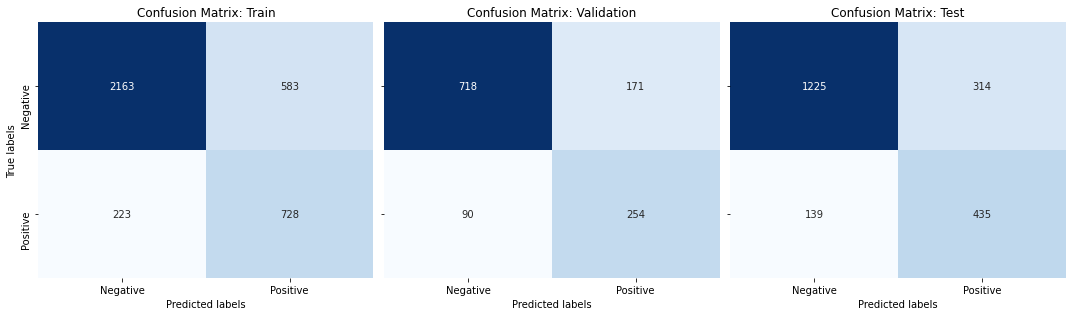

Metrics for Train: AUC = 0.8548, Precision = 0.56, Recall = 0.77, F1 = 0.64
Metrics for Validation: AUC = 0.8513, Precision = 0.60, Recall = 0.74, F1 = 0.66
Metrics for Test: AUC = 0.8582, Precision = 0.58, Recall = 0.76, F1 = 0.66


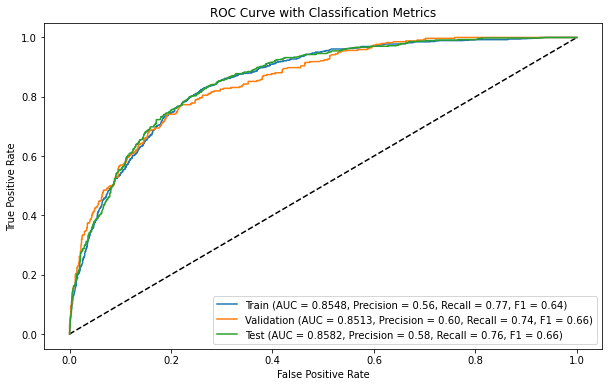

In [16]:
# Train
train_metrics = evaluate_model(lgb_model2, X_train, y_train, best_threshold)
print("Training Data meticas:")
print(train_metrics)
print(y_train.value_counts(1))

y_pred_proba_lgb = lgb_model2.predict_proba(X_train)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)

# test
test_metrics = evaluate_model(lgb_model2, X_test, y_test, best_threshold)
print("\n Test Data metricas:")
print(test_metrics)
print(y_train.value_counts(1))

y_pred_proba_lgb = lgb_model2.predict_proba(X_train)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)

# val
validation_metrics = evaluate_model(lgb_model2, X_val, y_val, best_threshold)
print("\n Validation Data metrica:")
print(validation_metrics)
print(y_train.value_counts(1))

y_pred_proba_lgb = lgb_model2.predict_proba(X_train)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)



lgb_model =lgb_model2
datasets = {
    'train': (X_train, y_train),
    'validation': (X_val, y_val),
    'test': (X_test, y_test)
}
best_threshold = best_threshold

plot_confusion_matrices(lgb_model, datasets, best_threshold)

# Example usage
datasets = {
    'Train': (X_train, y_train),
    'Validation': (X_val, y_val),
    'Test': (X_test, y_test)
}

evaluate_and_plot(lgb_model2, datasets)


In [17]:
# Assuming models are stored in a dictionary like before
models = {
    'LightGBM_2': lgb_model2,
}

for name, model in models.items():
    joblib.dump(model, f'objetos/{name.replace(" ", "_")}_model.joblib')


### Ahora se refinará el ejercicio con SMOTE para tratar de identificar si se gana o no en performance condica metodologia

In [18]:
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)## Sólo voy a afectar el train, luego procedo a realizar CV y luego valido con mi fuera de muestra y mantengo lo demás constante

In [19]:
def objective_lgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 150)
    max_depth = trial.suggest_int('max_depth', 1, 5)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    num_leaves = trial.suggest_int('num_leaves', 20, 31)
    min_child_samples = trial.suggest_int('min_child_samples', 50, 100)
    min_child_weight = trial.suggest_float('min_child_weight', 0.001, 10.0)
    reg_alpha = trial.suggest_float('reg_alpha', 15, 20)
    reg_lambda = trial.suggest_float('reg_lambda', 12, 20)

    classifier = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42
    )
    score = cross_val_score(classifier, X, y, cv=5, scoring='roc_auc').mean()
    return score
study_lgbm = optuna.create_study(direction='maximize', study_name='LiGHT')
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-05-07 10:17:30,399] A new study created in memory with name: LiGHT
[I 2024-05-07 10:17:30,637] Trial 0 finished with value: 0.8652015602288827 and parameters: {'n_estimators': 119, 'max_depth': 3, 'learning_rate': 0.1310391509035019, 'num_leaves': 28, 'min_child_samples': 50, 'min_child_weight': 6.873339372227998, 'reg_alpha': 17.667088554156894, 'reg_lambda': 17.34295949337662}. Best is trial 0 with value: 0.8652015602288827.
[I 2024-05-07 10:17:30,948] Trial 1 finished with value: 0.8659564940817293 and parameters: {'n_estimators': 133, 'max_depth': 4, 'learning_rate': 0.09258949137861482, 'num_leaves': 23, 'min_child_samples': 62, 'min_child_weight': 1.4548777114291815, 'reg_alpha': 16.996755942490115, 'reg_lambda': 19.988363538787766}. Best is trial 1 with value: 0.8659564940817293.
[I 2024-05-07 10:17:31,176] Trial 2 finished with value: 0.8523108217955482 and parameters: {'n_estimators': 124, 'max_depth': 2, 'learning_rate': 0.0314387802008839, 'num_leaves': 24, 'min_chil

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] 

[I 2024-05-07 10:17:35,371] Trial 16 finished with value: 0.8529850199568019 and parameters: {'n_estimators': 115, 'max_depth': 5, 'learning_rate': 0.010499856726411322, 'num_leaves': 31, 'min_child_samples': 86, 'min_child_weight': 2.8700171784392343, 'reg_alpha': 16.056695001461613, 'reg_lambda': 13.535120849409207}. Best is trial 14 with value: 0.8672767762428247.


Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-05-07 10:17:35,651] Trial 17 finished with value: 0.8665190427370846 and parameters: {'n_estimators': 128, 'max_depth': 4, 'learning_rate': 0.18801416539553029, 'num_leaves': 27, 'min_child_samples': 56, 'min_child_weight': 4.7255524893229195, 'reg_alpha': 15.723188167030763, 'reg_lambda': 13.254694951829421}. Best is trial 14 with value: 0.8672767762428247.
[I 2024-05-07 10:17:35,953] Trial 18 finished with value: 0.8672534216723055 and parameters: {'n_estimators': 107, 'max_depth': 5, 'learning_rate': 0.13195696914170438, 'num_leaves': 24, 'min_child_samples': 68, 'min_child_weight': 2.515910650199158, 'reg_alpha': 16.37712570307041, 'reg_lambda': 13.109236910072974}. Best is trial 14 with value: 0.8672767762428247.
[I 2024-05-07 10:17:36,252] Trial 19 finished with value: 0.8659955534924629 and parameters: {'n_estimators': 106, 'max_depth': 4, 'learning_rate': 0.12769523901987218, 'num_leaves': 28, 'min_child_samples': 69, 'min_child_weight': 4.212434300893751, 'reg_alpha': 

In [20]:
study_lgbm.trials_dataframe().iloc[15]

number                                              15
value                                          0.86653
datetime_start              2024-05-07 10:17:34.779940
datetime_complete           2024-05-07 10:17:35.054929
duration                        0 days 00:00:00.274989
params_learning_rate                          0.198829
params_max_depth                                     4
params_min_child_samples                            54
params_min_child_weight                       3.069523
params_n_estimators                                123
params_num_leaves                                   25
params_reg_alpha                             15.910946
params_reg_lambda                            13.435169
state                                         COMPLETE
Name: 15, dtype: object

In [21]:
lgb_model3 = LGBMClassifier(**study_lgbm.best_params)
lgb_model3.fit(X, y)

LGBMClassifier(learning_rate=0.19757485589396961, max_depth=5,
               min_child_samples=56, min_child_weight=3.176211978870936,
               n_estimators=126, num_leaves=24, reg_alpha=15.941496197880271,
               reg_lambda=13.208953417585215)

In [22]:
models = {
    'LightGBM': lgb_model3,
}

In [23]:

best_thresholds = {}
for name, model in models.items():
    best_threshold, max_f1 = find_best_threshold(model, X_val, y_val)
    best_thresholds[name] = {'Threshold': best_threshold, 'Max F1': max_f1}
    print(f"Best threshold for {name} is {best_threshold} with F1 Score: {max_f1}")

Best threshold for LightGBM is 0.44223045200155625 with F1 Score: 0.6511085180863477


Training Data meticas:
{'ROC AUC': 0.8623638015107339, 'True Negatives': 2024, 'False Positives': 722, 'False Negatives': 162, 'True Positives': 789, 'Precision': 0.5221707478491066}
0    0.742764
1    0.257236
Name: Churn, dtype: float64

 Test Data metricas:
{'ROC AUC': 0.843029547672252, 'True Negatives': 1112, 'False Positives': 427, 'False Negatives': 95, 'True Positives': 479, 'Precision': 0.5286975717439294}
0    0.742764
1    0.257236
Name: Churn, dtype: float64

 Validation Data metrica:
{'ROC AUC': 0.8401555183509039, 'True Negatives': 655, 'False Positives': 234, 'False Negatives': 66, 'True Positives': 278, 'Precision': 0.54296875}
0    0.742764
1    0.257236
Name: Churn, dtype: float64


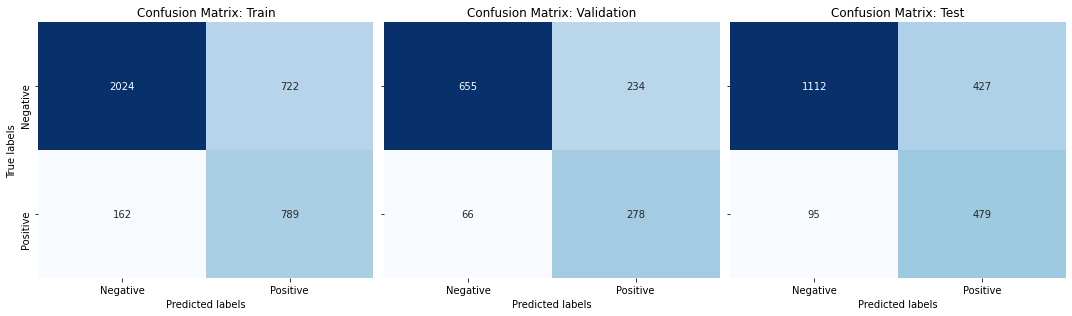

Metrics for Train: AUC = 0.8624, Precision = 0.52, Recall = 0.83, F1 = 0.64
Metrics for Validation: AUC = 0.8402, Precision = 0.54, Recall = 0.81, F1 = 0.65
Metrics for Test: AUC = 0.8430, Precision = 0.53, Recall = 0.83, F1 = 0.65


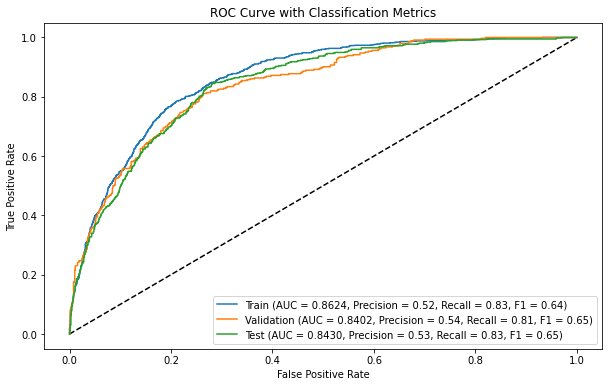

In [24]:
# Train
train_metrics = evaluate_model(lgb_model3, X_train, y_train, best_threshold)
print("Training Data meticas:")
print(train_metrics)
print(y_train.value_counts(1))

y_pred_proba_lgb = lgb_model3.predict_proba(X_train)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)

# test
test_metrics = evaluate_model(lgb_model3, X_test, y_test, best_threshold)
print("\n Test Data metricas:")
print(test_metrics)
print(y_train.value_counts(1))

y_pred_proba_lgb = lgb_model3.predict_proba(X_train)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)

# val
validation_metrics = evaluate_model(lgb_model3, X_val, y_val, best_threshold)
print("\n Validation Data metrica:")
print(validation_metrics)
print(y_train.value_counts(1))

y_pred_proba_lgb = lgb_model3.predict_proba(X_train)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)

lgb_model =lgb_model3
datasets = {
    'train': (X_train, y_train),
    'validation': (X_val, y_val),
    'test': (X_test, y_test)
}
best_threshold = best_threshold

plot_confusion_matrices(lgb_model, datasets, best_threshold)

# Example usage
datasets = {
    'Train': (X_train, y_train),
    'Validation': (X_val, y_val),
    'Test': (X_test, y_test)
}

evaluate_and_plot(lgb_model3, datasets)


## Save all

In [25]:
# Assuming models are stored in a dictionary like before
models = {
    'LightGBM_3': lgb_model3,
}

for name, model in models.items():
    joblib.dump(model, f'objetos/{name.replace(" ", "_")}_model.joblib')


In [26]:
X_train_df = pd.DataFrame(X)
y_train_df = pd.DataFrame(y)

In [27]:
# Save to CSV
X_train_df.to_csv('objetos/datasets/X_train_smote.csv', index=False)
y_train_df.to_csv('objetos/datasets/y_train_smote.csv', index=False)


### Para finalizar deseo realizar un ejercicio donde con ayuda de optuna quiero apuntar a maximizar dos metricas importantes el AUC y la precisión

In [28]:
def objective_lgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 150)
    max_depth = trial.suggest_int('max_depth', 1, 5)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    num_leaves = trial.suggest_int('num_leaves', 20, 31)
    min_child_samples = trial.suggest_int('min_child_samples', 50, 100)
    min_child_weight = trial.suggest_float('min_child_weight', 0.001, 10.0)
    reg_alpha = trial.suggest_float('reg_alpha', 11, 20)
    reg_lambda = trial.suggest_float('reg_lambda', 12, 20)
    classifier = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42
    )

    scores = cross_validate(classifier, X, y, cv=5, scoring={'roc_auc': 'roc_auc', 'precision': 'precision'}, n_jobs=-1)
    mean_roc_auc = scores['test_roc_auc'].mean()
    mean_precision = scores['test_precision'].mean()
    return mean_roc_auc, mean_precision

study_lgbm = optuna.create_study(directions=['maximize', 'maximize'], study_name='LiGHT') ## optimización multimetrica se requiere un mayor auc acompañado de alta precisión para detectar los churn y evitar la fuga
study_lgbm.optimize(objective_lgbm, n_trials=30)



[I 2024-05-07 10:17:40,932] A new study created in memory with name: LiGHT
[I 2024-05-07 10:17:42,405] Trial 0 finished with values: [0.8655963945344937, 0.7589804453953803] and parameters: {'n_estimators': 147, 'max_depth': 3, 'learning_rate': 0.12933734508779482, 'num_leaves': 27, 'min_child_samples': 61, 'min_child_weight': 7.957188918867777, 'reg_alpha': 15.773081755935316, 'reg_lambda': 17.927853909308922}. 
[I 2024-05-07 10:17:43,446] Trial 1 finished with values: [0.8433811325353024, 0.7220910259977003] and parameters: {'n_estimators': 109, 'max_depth': 2, 'learning_rate': 0.015853212871665537, 'num_leaves': 28, 'min_child_samples': 97, 'min_child_weight': 2.3483932887876002, 'reg_alpha': 17.15504792426344, 'reg_lambda': 18.591207570214117}. 
[I 2024-05-07 10:17:44,419] Trial 2 finished with values: [0.8680840408625056, 0.7656833035159487] and parameters: {'n_estimators': 135, 'max_depth': 4, 'learning_rate': 0.0986678440637432, 'num_leaves': 20, 'min_child_samples': 62, 'min_ch

In [29]:
# Display the best trial information
best_trials = study_lgbm.best_trials
for idx, trial in enumerate(best_trials):
    print(f"Best Trial {idx + 1}:")
    print("  Value: ", trial.values)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


Best Trial 1:
  Value:  [0.8713999965615123, 0.7722820683382189]
  Params: 
    n_estimators: 129
    max_depth: 5
    learning_rate: 0.18776620153655604
    num_leaves: 21
    min_child_samples: 84
    min_child_weight: 8.663702101853966
    reg_alpha: 11.955457950164098
    reg_lambda: 18.20549338190356


In [32]:
study_lgbm.best_trials

[FrozenTrial(number=26, state=TrialState.COMPLETE, values=[0.8713999965615123, 0.7722820683382189], datetime_start=datetime.datetime(2024, 5, 7, 10, 17, 49, 819382), datetime_complete=datetime.datetime(2024, 5, 7, 10, 17, 50, 94891), params={'n_estimators': 129, 'max_depth': 5, 'learning_rate': 0.18776620153655604, 'num_leaves': 21, 'min_child_samples': 84, 'min_child_weight': 8.663702101853966, 'reg_alpha': 11.955457950164098, 'reg_lambda': 18.20549338190356}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=150, log=False, low=100, step=1), 'max_depth': IntDistribution(high=5, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.01, step=None), 'num_leaves': IntDistribution(high=31, log=False, low=20, step=1), 'min_child_samples': IntDistribution(high=100, log=False, low=50, step=1), 'min_child_weight': FloatDistribution(high=10.0, log=False, low=0.001, step=None), 'reg_

In [33]:
for param_name, param_value in trial.params.items():
    print(f"'{param_name}': {param_value},")

'n_estimators': 129,
'max_depth': 5,
'learning_rate': 0.18776620153655604,
'num_leaves': 21,
'min_child_samples': 84,
'min_child_weight': 8.663702101853966,
'reg_alpha': 11.955457950164098,
'reg_lambda': 18.20549338190356,


In [34]:
params={'n_estimators': 120,
'max_depth': 4,
'learning_rate': 0.09119121977107351,
'num_leaves': 25,
'min_child_samples': 60,
'min_child_weight': 4.236532735988061,
'reg_alpha': 13.358182673111719,
'reg_lambda': 18.3945976043336}

In [35]:
lgb_model4 = LGBMClassifier(**params)
lgb_model4.fit(X, y)

LGBMClassifier(learning_rate=0.09119121977107351, max_depth=4,
               min_child_samples=60, min_child_weight=4.236532735988061,
               n_estimators=120, num_leaves=25, reg_alpha=13.358182673111719,
               reg_lambda=18.3945976043336)

In [36]:
models = {
    'LightGBM4': lgb_model4,
}

In [37]:
best_thresholds = {}
for name, model in models.items():
    best_threshold, max_f1 = find_best_threshold(model, X_val, y_val)
    best_thresholds[name] = {'Threshold': best_threshold, 'Max F1': max_f1}
    print(f"Best threshold for {name} is {best_threshold} with F1 Score: {max_f1}")

Best threshold for LightGBM4 is 0.5203035321755293 with F1 Score: 0.658354114713217


Training Data meticas:
{'ROC AUC': 0.8580512482356518, 'True Negatives': 2133, 'False Positives': 613, 'False Negatives': 200, 'True Positives': 751, 'Precision': 0.5505865102639296}
0    0.742764
1    0.257236
Name: Churn, dtype: float64
 
 Test Data metricas:
{'ROC AUC': 0.8447949141145547, 'True Negatives': 1161, 'False Positives': 378, 'False Negatives': 126, 'True Positives': 448, 'Precision': 0.5423728813559322}
0    0.742764
1    0.257236
Name: Churn, dtype: float64

 Validation Data metrica:
{'ROC AUC': 0.8424853506683757, 'True Negatives': 695, 'False Positives': 194, 'False Negatives': 81, 'True Positives': 263, 'Precision': 0.5754923413566739}
0    0.742764
1    0.257236
Name: Churn, dtype: float64


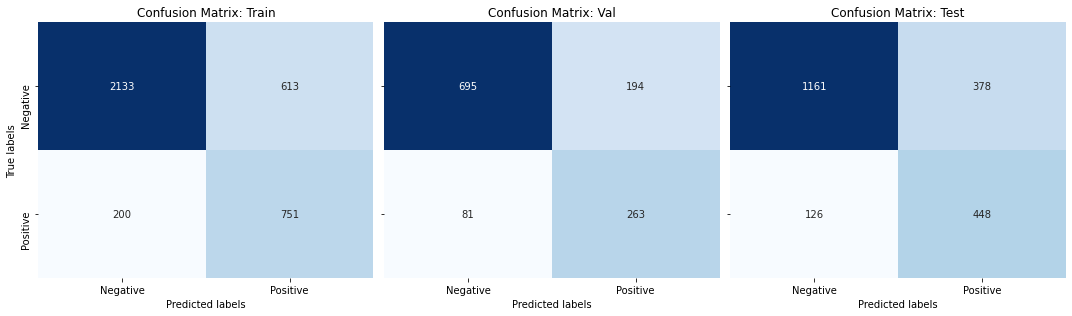

Metrics for Train: AUC = 0.8581, Precision = 0.55, Recall = 0.79, F1 = 0.65
Metrics for Val: AUC = 0.8425, Precision = 0.58, Recall = 0.76, F1 = 0.66
Metrics for Test: AUC = 0.8448, Precision = 0.54, Recall = 0.78, F1 = 0.64


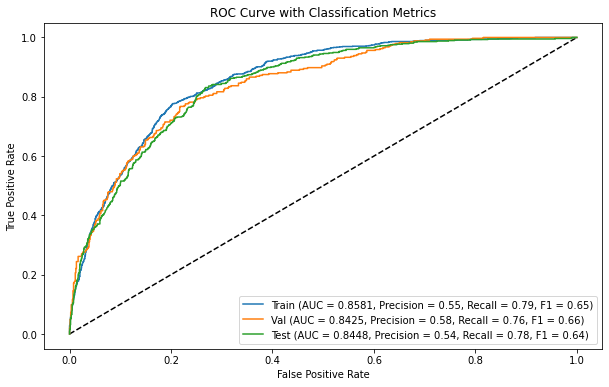

In [38]:
# Train
train_metrics = evaluate_model(lgb_model4, X_train, y_train, best_threshold)
print("Training Data meticas:")
print(train_metrics)
print(y_train.value_counts(1))

y_pred_proba_lgb = lgb_model4.predict_proba(X_train)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)

#test
test_metrics = evaluate_model(lgb_model4, X_test, y_test, best_threshold)
print(" \n Test Data metricas:")
print(test_metrics)
print(y_train.value_counts(1))

y_pred_proba_lgb = lgb_model4.predict_proba(X_train)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)

#val
validation_metrics = evaluate_model(lgb_model4, X_val, y_val, best_threshold)
print("\n Validation Data metrica:")
print(validation_metrics)
print(y_train.value_counts(1))

y_pred_proba_lgb = lgb_model4.predict_proba(X_train)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)

lgb_model =lgb_model4
datasets = {
    'train': (X_train, y_train),
    'val': (X_val, y_val),
    'test': (X_test, y_test)
}
best_threshold = best_threshold

plot_confusion_matrices(lgb_model, datasets, best_threshold)

# Example usage
datasets = {
    'Train': (X_train, y_train),
    'Val': (X_val, y_val),
    'Test': (X_test, y_test)
}

evaluate_and_plot(lgb_model4, datasets)


* * Se logra un mejor modelo con el ultimo ejercicio donde se controla el overfitting y se trata de minimizar los individuos que se predicen como no churn uy en realidad se van

In [39]:
#guardo el modelo final
models = {
    'LightGBM_final_con_smote': lgb_model4,
}
for name, model in models.items():
    joblib.dump(model, f'objetos/{name.replace(" ", "_")}_model.joblib')


In [40]:
importances = lgb_model4.feature_importances_
gain_importances = lgb_model4.booster_.feature_importance(importance_type='gain') ##  Si es "ganancia", el resultado contiene las ganancias totales de las divisiones que utilizan la función.
feature_names = X_train.columns
df_feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gain_importances
}).sort_values(by='Importance', ascending=False)

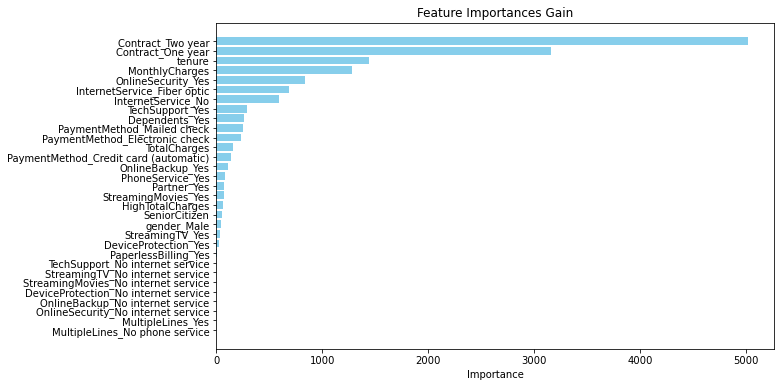

In [41]:
plt.figure(figsize=(10, 6))
plt.barh(df_feature_importances['Feature'], df_feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances Gain')
plt.gca().invert_yaxis()
plt.show()

* La variable más importante Contrado de 2 años o de un año, el tiempo con la compañia de telecomunicaciones tal cual como se habia visto desde el análisis exploratorio y los cargos mensiales que a medida que aumentan se tienden a salir o retirar de la compañia.

In [42]:
explainer = shap.TreeExplainer(lgb_model4)
shap_values = explainer.shap_values(X_test)

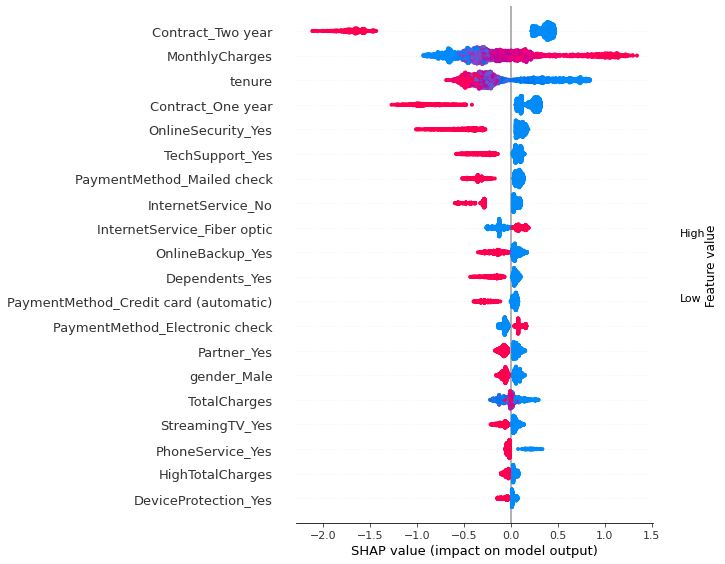

In [43]:
shap.summary_plot(shap_values[1], X_test, feature_names=X_train.columns)

El churn como lo identificamos en el análisis exploratorio tanto los contratos de más de un año disminuye la probabilidad de fuga esto se evidencia desde las variables Contract mayores a dos años y a un año y la variable ternure (número de meses que el cliente ha estado con la compañía).
* Ante mayores cargos mensuales más es la probabilidad de churn (respaldado por los hallazgos anteriores).
* Si tiene seguridad online el clente es más propenso a no fugarse.

* Los anteriores hallazgos son fuente fundamental para realizar campañas de blindaje y ofertas personalizadas a clientes con alta probabilidad de fuga en la compañia y así fidelizarlos.

* * Evaluación final para indicarle al negocio una estartegia personalizada para empezar a abordar clientes.

In [44]:
y_pred_proba = lgb_model4.predict_proba(X_val)[:, 1] ## tomo mejor modelo sobre validación

In [45]:
X_val_T=pd.concat([y_val,pd.Series(y_pred_proba),X_val],axis=1).rename(columns={0:'prob'})

* Uso optbining para obtener el mejor corte para que el negocio personalice sus campañas por niveles de probabilidades

<AxesSubplot:>

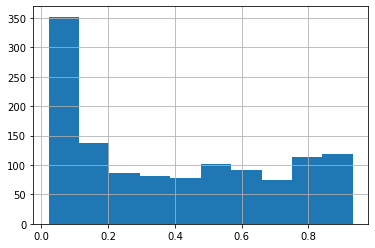

In [46]:
X_val_T['prob'].hist()

In [47]:
X_val_T['bin_probs_']=pd.cut(X_val_T['prob'],bins=5)

In [48]:
X_val_T.head()

,Churn,prob,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,HighTotalCharges,bin_probs_
0,0,0.293342,0,0.166667,0.027902,0.025040,1,0,1,1,...,1,0,0,0,0,1,0,0,0,"(0.204, 0.386]"
1,1,0.878984,0,0.125000,0.563029,0.079368,0,0,0,1,...,0,0,0,0,1,0,1,0,0,"(0.751, 0.933]"
2,0,0.078703,0,0.944444,0.714499,0.687226,0,1,0,1,...,0,0,0,1,1,0,0,0,1,"(0.0204, 0.204]"
3,0,0.053965,0,0.291667,0.167912,0.086730,0,0,0,0,...,0,0,0,1,0,0,0,1,0,"(0.0204, 0.204]"
4,1,0.737984,0,0.527778,0.807175,0.433689,1,0,1,1,...,0,1,0,0,1,0,0,0,1,"(0.569, 0.751]"


In [49]:
X_val_T.groupby('bin_probs_').agg({'Churn':'mean'}) 

,Churn
bin_probs_,
"(0.0204, 0.204]",0.071575
"(0.204, 0.386]",0.125749
"(0.386, 0.569]",0.279330
"(0.569, 0.751]",0.443114
"(0.751, 0.933]",0.709957


* La propuesta radica en realizar y testiar ofertas personalizadas a clientes con probabilidad de fuga mayor a 0.53 y ser más agresivo con los que tienen mayores probabilidades de fuga ofrenciendo paquetes de seguridad en linea y soporte tecnico por ejemplo.


* Propuestas de mejora: Tunear el modelo de nuevo descartando las variables que no fueron importantes sin afectar las metricas, ni afectar la generalización.
* Pasos a seguir: Llevar el modelo a producción luego de las validaciones y aclarar las dudas del negocio.

Referencias:

lightgbm:
* Guolin Ke, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, Tie-Yan Liu. “LightGBM: A Highly Efficient Gradient Boosting Decision Tree.” Advances in Neural Information Processing Systems 30 (NIPS 2017), pp. 3149-3157.

Regresión logística:
* sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Random forest:
sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Decision tree
* Sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Optuna framework:
Takuya Akiba, Shotaro Sano, Toshihiko Yanase, Takeru Ohta, and Masanori Koyama. 2019.
Optuna: A Next-generation Hyperparameter Optimization Framework. In KDD.
https://optuna.org/#paper

xgboost
* https://xgboost.readthedocs.io/en/stable/

Smote
* https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

Shap values
* https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability
* https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

Support Vector Machines
* https://scikit-learn.org/stable/modules/svm.html

Pandas (manipulación)
* https://pandas.pydata.org/